# 0. Checking CUDA Availability + Making Sure GPU is Utilized

In [56]:
import torch
import math
import numpy
import matplotlib.pyplot as plt

print("PyTorch Version: " + torch.__version__)
print("CUDA Availability: " + str(torch.cuda.is_available()))
print("Device Count: " + str(torch.cuda.device_count()) + "\n")

current = torch.cuda.current_device()

print("Current Device Index: " + str(current))
print("Current Device Object: " + str(torch.cuda.device(current)))
print("Current Device Name: " + torch.cuda.get_device_name(current))

PyTorch Version: 2.4.1+cu124
CUDA Availability: True
Device Count: 1

Current Device Index: 0
Current Device Object: <torch.cuda.device object at 0x75c23c154be0>
Current Device Name: NVIDIA GeForce RTX 4060 Laptop GPU


# 1-1a. Simulate a Function

The function I will be simulating is $ f(x) = sgn(\frac{sin(4x)}{1.1 + cos(2x)}) $.

### 1. Generating Training Data

torch.Size([10000, 2])
tensor([[-5.0000, -1.0000],
        [-4.9990, -1.0000],
        [-4.9980, -1.0000],
        ...,
        [ 4.9970,  1.0000],
        [ 4.9980,  1.0000],
        [ 4.9990,  1.0000]])


Text(0, 0.5, 'f(x)')

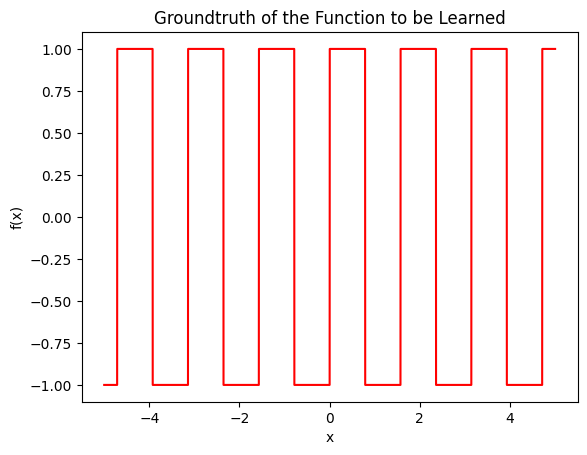

In [57]:
# Function representation of the simulated function
def groundtruth_function(x):
    fx = math.sin(4 * x) / (1.1 + math.cos(2 * x))

    if fx == 0:
        return 0
    elif fx > 0:
        return 1
    else:
        return -1

# List to contain generated function data
function_data = []

#Get [x, f(x)] pairs for all points between start and end, at the interval indicated by jump_rate
start = -5
end = 5
jump_rate = 0.001

while start < end:
    function_data.append([start, groundtruth_function(start)])
    start += jump_rate

#Convert list into PyTorch tensor
function_data = torch.tensor(function_data)

#Print the size and content of the function data as a sanity check
print(function_data.size())
print(function_data)

#Plot the function data as another sanity check
plt.plot(function_data[:, 0], function_data[:, 1], color='r', label='Function Data')
plt.title('Groundtruth of the Function to be Learned')
plt.xlabel('x')
plt.ylabel('f(x)')



### 2. Extending Training Data (Parameter Generation)

# 1-1b. Train on Actual Task

# 1-2. Optimization

# 1-3. Generalization